# はじめに
ニューラルネットワークの予測の不確実性を算出する手法を検証します。

### 概要
- 連続値を予測する回帰のためのニューラルネットワークを構築
- deep Gaussian process で予測の不確実性を算出


# Gaussian process (ガウス過程)  
ガウス過程では、データセット$\{(x_1, y_1), ..., (x_n, y_n)\}$の関数$y=f(x)$を、多変量正規分布を用いてモデル化します。  
平均関数$m(x_i)$とカーネル関数$k(x_i,x_j)$を用いて下記のように定義します。  
$$
p\left(\begin{bmatrix}
   y_1 \\
   \vdots \\
   y_n
\end{bmatrix}\right)
= \mathcal{N}\left(
\begin{bmatrix}
   y_1 \\
   \vdots \\
   y_n
\end{bmatrix}
\middle|
\begin{bmatrix}
   m(x_1) \\
   \vdots \\
   m(x_n)
\end{bmatrix}
,
\begin{bmatrix}
   k(x_1,x_1) & \dots & k(x_1,x_n)\\
   \vdots &  \ddots & \vdots \\
   k(x_n,x_1) & \dots & k(x_n,x_n)
\end{bmatrix}
\right)
$$
このように定義される関数を$f\sim GP(m,k)$と書きます。  


$Y=[y_1,...,y_n]^T, X=[x_1, ..., x_n]^T,m(x_i)=0,$  
$k(X,X)=\begin{bmatrix}
   k(x_1,x_1) & \dots & k(x_1,x_n)\\
   \vdots &  \ddots & \vdots \\
   k(x_n,x_1) & \dots & k(x_n,x_n)
\end{bmatrix}$
の場合を例に説明します。  
また、ノイズ$\epsilon \sim \mathcal{N}(0,\beta^{-1})$を考慮して、$y=f(x)+\epsilon$を考えると、$f \sim GP(0,k(x_i,x_j)+\delta_{ij}\beta^{-1})$となります。

教師データ$\{X,Y\}$を用いて、テストデータ$X^*$の予測を行う場合は、同時分布を考えます。
$$
p(Y^*,Y|X^*,X) =  \mathcal{N}\left(
\begin{bmatrix}
Y^* \\
Y
\end{bmatrix}
\middle|
0,
\begin{bmatrix}
   k(X^*,X^*) + \beta^{-1}I & k(X^*,X) \\
   K(X,X^*) & K(X,X)+ \beta^{-1}I
\end{bmatrix}
\right)
$$
この同時分布から条件付き確率を求めると下記のように書くことができます。  
$$
p(Y^*|Y,X^*,X) = \mathcal{N}(Y^*|\mu^*,\Sigma^*) \\
\mu^* = k(X^*,X)(k(X,X)+\beta^{-1}I)Y \\
\Sigma^* = k(X^*,X^*)+\beta^{-1}I-k(X^*,X)(k(X,X)+\beta^{-1}I)^{-1}k(X,X^*)
$$
このように、テストデータの予測値の事後分布を求めることができます。  

カーネル関数としては、$k(x_i,x_j)=\sigma^2\exp(-\frac{1}{2}w_l\sum_{l}(x_{il}-x_{jl})^2)$のような関数が用いられます。  
$l$は$x$の要素のインデックスで、$w_l$はパラメータです。  
$w_l$を最適化することで、予測性能が高いモデルを得ることができます。  


# deep Gaussian process (深層ガウス過程)  
ニューラルネットワークの各層にガウス過程を用いたものが、深層ガウス過程になります。  
3層のニューラルネットワークを考え、入力層を$X^1$、中間層を$X^2$、出力層を$Y$とします。  
中間層と出力層は下記のようにガウス過程で定義されます。  
$$
f^{X^2} \sim GP(0,k^1(X^1,X^1)) \\
f^Y \sim GP(0,k^2(X^2,X^2))
$$

深層ガウス過程では、学習のためにinducing points（誘導点）を導入します。  
3層のニューラルネットワークの場合は、入力層の誘導点$Z_1$と、中間層の誘導点$Z_2$を導入します。  
誘導点は変分推論で最適化する変数で、観測データを用いて、誘導点、平均関数、カーネル関数の最適化を行います。  
この最適化は、大規模な観測データを少数の誘導点に圧縮していると捉えることができます。  
新たなデータが与えられた場合は、学習結果を用いて事後分布を計算します。





# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install gpytorch
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 9.2 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
PyTorch: 2.0.1+cu118
Mon Sep 25 05:59:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
        

### 3. データセットの作成  
線形回帰用のデータセットを作成します。  
ただし、学習には[-1,1]の範囲のデータは使用しません。  


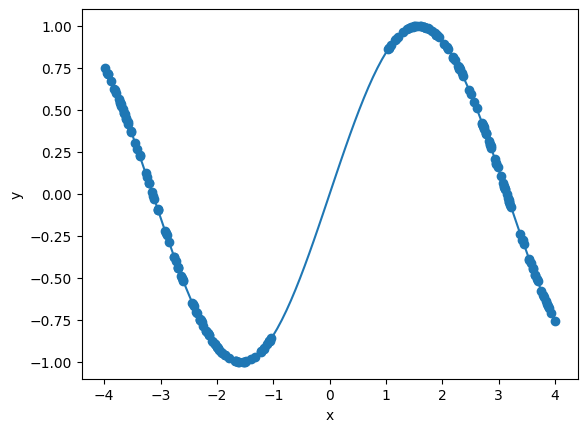

In [ ]:
def make_dataset(seed, plot=0, batch_size=64):
    np.random.seed(seed)

    x_true = np.linspace(-4, 4, 100)
    y_true = np.sin(x_true)

    x = np.concatenate([np.random.uniform(-4, -1, 100), np.random.uniform(1, 4, 100)])
    y = np.sin(x)

    # データをPyTorchのテンソルに変換
    x = torch.from_numpy(x).float().view(-1, 1)
    y = torch.from_numpy(y).float()
    x_true = torch.from_numpy(x_true).float().view(-1, 1)

    # グラフを描画
    if plot == 1:
        plt.plot(x_true, y_true)
        plt.scatter(x, y)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    dataset = torch.utils.data.TensorDataset(x, y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

_ = make_dataset(0, plot=1)

### ニューラルネットワークの定義
GPyTorchのサンプルコードを参考にGP layerと3層のニューラルネットワークを定義します。  
隠れ層のユニット数は10としてあります。  


In [ ]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)



In [ ]:
class DeepGPModel(DeepGP):
    def __init__(self, input_dim=1):
        super().__init__()
        num_hidden_dims = 10

        self.input_layer = ToyDeepGPHiddenLayer(
            input_dims=input_dim,
            output_dims=num_hidden_dims,
            mean_type='linear',
        )

        self.hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=num_hidden_dims,
            output_dims=num_hidden_dims,
            mean_type='linear',
        )

        self.last_layer = ToyDeepGPHiddenLayer(
            input_dims=num_hidden_dims,
            output_dims=None,
            mean_type='constant',
        )

        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        h = self.input_layer(inputs)
        h = self.hidden_layer(h)
        output = self.last_layer(h)
        return output

    def predict(self, x):
        preds = self.likelihood(self.forward(x))
        return preds.mean, preds.variance

### 4. 学習
deep Gaussian processの学習を行います。


In [ ]:
batch_size=128
data_loader = make_dataset(0, batch_size=batch_size)

model = DeepGPModel()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = model.to(device)

num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, len(data_loader.dataset), beta=0.01))

for i in range(num_epochs):
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()


### 5. 予測
予測結果と標準偏差を描画します。


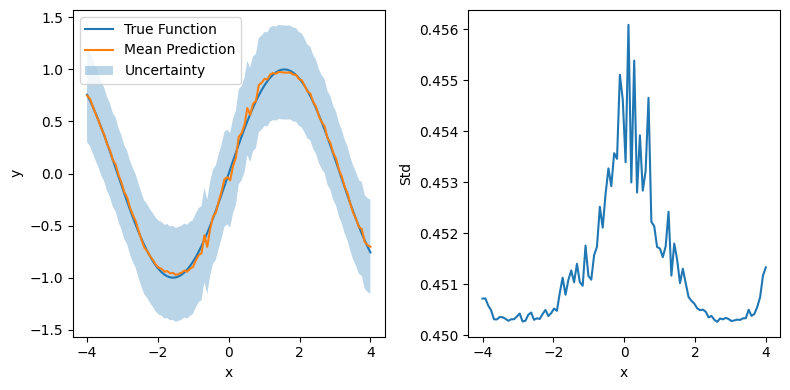

In [ ]:
x_true = np.linspace(-4, 4, 100)
y_true = np.sin(x_true)
x_true = torch.from_numpy(x_true).float().view(-1, 1)

model.eval()
x_true = x_true.to(device)
y_preds = []
with torch.no_grad():
    y_mean, y_var = model.predict(x_true)

x_true = x_true.to('cpu')
y_mean = y_mean.to('cpu').mean(0)
y_var = y_var.to('cpu').mean(0)
y_std = np.sqrt(y_var)


# グラフの描画
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(x_true, y_true, label='True Function')
plt.plot(x_true, y_mean, label='Mean Prediction')
plt.fill_between(x_true.flatten(), y_mean.flatten() - y_std.flatten(), y_mean.flatten() + y_std.flatten(), alpha=0.3, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


plt.subplot(122)
plt.plot(x_true, y_std)
plt.xlabel('x')
plt.ylabel('Std')

plt.tight_layout()
plt.show()

# おわりに


### 今回の結果
予測の不確実性は、x最小値および最大値付近とデータが含まれない[-1,1]の範囲で大きくなっています。  
データ数が少なく、予測が不確実と考えられる領域と、予測の標準偏差が大きい領域が一致しているため、想定通り予測の不確実性が算出できていると考えられます。  
ただし、不確実性の差は非常に小さいため、今回の設定での不確実性の算出は他の手法の方が優れているかもしれません。

### 次にやること
予測の不確実性を算出する他の手法も検証したいと思います。  


### 参考資料
- 須山敦志, ベイズ深層学習, 2019.
- A. C. Damianou and N. D. Lawrence, Deep Gaussian Processes, AISTATS, 2013.
- H. Salimbeni and M. P. Deisenroth, Doubly Stochastic Variational Inference
for Deep Gaussian Processes, NeurIPS, 2017.
- GPyTorch https://docs.gpytorch.ai/en/stable/examples/05_Deep_Gaussian_Processes/Deep_Gaussian_Processes.html
